# PCA and Autoencoders

Principal components analysis (PCA) comes in many shapes and forms, but the acronym itself refers to this process of zeroing out the mean of some given dataset, which comes in the form of a square matrix, calculating the covariance matrix, and then running either SVD or eigenvector decomposition on said covariance matrix.

So to start, here is a dataset.

In [1]:
import numpy as np
from sklearn.decomposition import PCA, KernelPCA

import matplotlib.pyplot as plt
from matplotlib import pylab

In [2]:
np.random.seed(0)

mean = (3,4)
cov = [[4,0],[0,4]]    # Alternatively - 4*np.eye(2)
gauss2d = np.random.multivariate_normal(mean, cov, 1000).T
mean2 = (5,18)
cov2 = [[10,2],[2,10]]
g2 = np.random.multivariate_normal(mean2, cov2, 1000).T
gauss2d = np.hstack((gauss2d, g2))

In [3]:
print(gauss2d.shape)

(2, 2000)


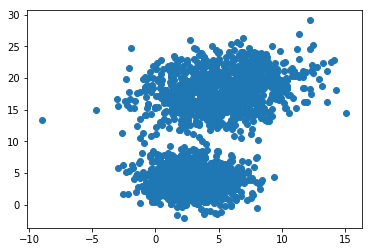

In [4]:
plt.scatter(gauss2d[0,:],gauss2d[1,:])
plt.show()

Now I toss this into my pca function, defined here

In [5]:
def my_pca(data, svd=False, whiten=False, norm=False, graph_evecs=False, project=False):
    # Zero out mean for all dimensions
    for i in range(data.shape[0]):
        data[i,:] = data[i,:] - np.mean(data[i,:])

    mu = data.mean(axis=1)
    sigma = np.cov(data, rowvar=True)/data.shape[0]
    
    if svd is True:
        U,S,V = np.linalg.svd(sigma) 
        # U is our eigenvectors, S is singular values =
        # (eigenvalues / sqrt(num elems in dataset - 1))
        # V is principal components * respective singular value, or scaled to unit norm
        evecs = U
        # For this program's flow
        
        if whiten is True:
            epsilon = 1e-9
            zca = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))
            
    else:
        evals, evecs = np.linalg.eigh(sigma)
        
        if norm is True:
            # Normalize eigenvectors
            evecs = evecs/np.linalg.norm(evecs)
            
        if whiten is True:
            epsilon = 1e-9
            D = np.diag(1. / np.sqrt(evals+epsilon))
            zca = np.dot(np.dot(evecs, D), evecs.T)
    
    
    if project is True:
        projection = np.dot(evecs, data)

        
    if graph_evecs is True:
        if data.shape[0] == 2:
            
            sigma_proj = projection.std(axis=0).mean()

            fig, ax = plt.subplots()
            ax.scatter(projection[0,:], projection[1,:])
            for axis in evecs:
                start, end = mu, mu + sigma_proj * axis
                ax.annotate(
                    '', xy=end, xycoords='data',
                    xytext=start, textcoords='data',
                    arrowprops=dict(facecolor='red', width=2.0))
            ax.set_aspect('equal')

            plt.show()

    loss = ((data - projection) **2).mean()
    print('mypca loss:', loss)

This is without normalizing the eigenvectors

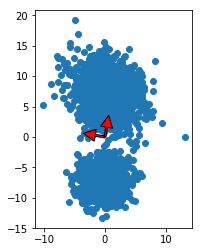

mypca loss: 13.646628377657956


In [6]:
my_pca(gauss2d, graph_evecs=True, project=True)

And to compare with normalization

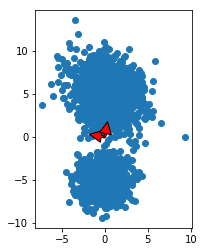

mypca loss: 12.4390649372057


In [7]:
my_pca(gauss2d, norm=True, graph_evecs=True, project=True)

So normalization helps rather slightly. But looking at the scale, it seems this output has been squashed together from before, as well as the original.

Loss in this case is calculated by mean squared error between the reproduction and the original dataset. The thing is that the reproduction is calculated using all two of the principal components (eigenvectors), so 100% of the variance in the dataset should be accounted for, meaning the loss should be at least near zero, if not zero.

Let's compare with sklearn's PCA implementation.

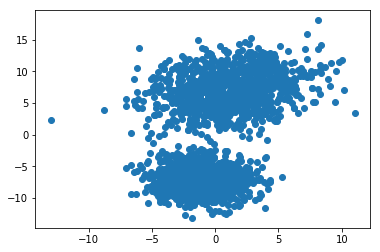

In [8]:
data = gauss2d.T
pca = PCA()
pca.fit(data)

# To calculate error the same way as before
transdata = pca.transform(data)
reproduction = pca.inverse_transform(transdata)

plt.scatter(reproduction[:,0],reproduction[:,1])
plt.show()

And our loss,

In [9]:
skloss = ((data - reproduction) **2).mean()
print('skloss:', skloss)

skloss: 3.8806665589780956e-31


Pretty much zero.

Now if I normalize the eigenvectors, like before,

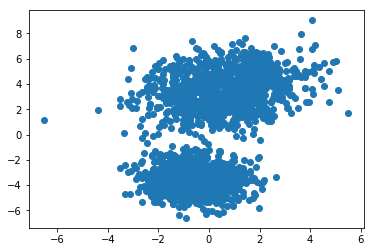

In [10]:
comps = pca.components_/np.linalg.norm(pca.components_)
reduceddata = np.dot(data - pca.mean_, comps)
reproduction = np.dot(reduceddata, comps.T) + pca.mean_

plt.scatter(reproduction[:,0],reproduction[:,1])
plt.show()

In [11]:
skloss = ((data - reproduction) **2).mean()
print('skloss:', skloss)

skloss: 8.129028166324453


So it's been squashed in again and the loss is a bit more than half of what my implementation returned.

Well that's strange. But let's try running this data through an autoencoder and see what happens. An autoencoder is apparently just like PCA except it introduces non-linearity. So it should perform at least as well as regular PCA, if not better, which, if so, would indicate that the dataset may be explained by some linear basis, which I think means that the dataset can be explained by one variable or attribute, as in there is a 100% correlation between the attributes. In other words, all eigenvectors are linearly dependent on one another.

On to implementing an autoencoder in tensorflow.

In [22]:
import tensorflow as tf

def autoencoder(data, alpha=0.01, iters=90000, batch_size=None):

    input_size = data.shape[0]
    layer1_size = int(input_size / 4)
    layer2_size = int(layer1_size / 2)

    x = tf.placeholder('float', [None, input_size])

    # Should use name scope, but this will do for now
    weights = {
        'encoder_h1': tf.Variable(tf.random_normal([input_size, layer1_size])),
        'encoder_h2': tf.Variable(tf.random_normal([layer1_size, layer2_size])),
        'decoder_h1': tf.Variable(tf.random_normal([layer2_size, layer1_size])),
        'decoder_h2': tf.Variable(tf.random_normal([layer1_size, input_size])),
    }
    biases = {
        'encoder_b1': tf.Variable(tf.random_normal([layer1_size])),
        'encoder_b2': tf.Variable(tf.random_normal([layer2_size])),
        'decoder_b1': tf.Variable(tf.random_normal([layer1_size])),
        'decoder_b2': tf.Variable(tf.random_normal([input_size])),
    }

    def encoder(data):
        layer1 = tf.nn.sigmoid(tf.add(tf.matmul(data, weights['encoder_h1']),
                                    biases['encoder_b1']))

        layer2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1, weights['encoder_h2']),
                                    biases['encoder_b2']))

        return layer2

    def decoder(data):
        layer1 = tf.nn.sigmoid(tf.add(tf.matmul(data, weights['decoder_h1']),
                                    biases['decoder_b1']))

        layer2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1, weights['decoder_h2']),
                                    biases['decoder_b2']))

        return layer2


    # MSE
    loss = tf.reduce_mean(tf.pow(x - decoder(encoder(x)), 2))
    optimizer = tf.train.AdamOptimizer(alpha).minimize(loss)

    init = tf.global_variables_initializer()


    with tf.Session() as sess:
        sess.run(init)
        
        disp = iters/5
        for i in range(1, iters+1):
            _, l = sess.run([optimizer, loss], feed_dict={x: data.T})

            if i % disp == 0 or i == 1:
                print('Iteration %i: Loss: %f' % (i, l))


In [23]:
gauss2d_flat = np.reshape(gauss2d, (1,4000))
autoencoder(gauss2d_flat)

Iteration 1: Loss: 32.658474
Iteration 18000: Loss: 32.516109
Iteration 36000: Loss: 32.516106
Iteration 54000: Loss: 32.516106
Iteration 72000: Loss: 32.516106
Iteration 90000: Loss: 32.516106


Loss is higher than PCA and it doesn't really seem to be learning. I can try a different optimizer or adding convolutional layers.